<img src="./media/Logo Element-01.jpg"><h1 align="center">Advanced Text Analysis with SpaCy and Scikit-Learn</h1>

This notebook was originally prepared for the workshop [Advanced Text Analysis with SpaCy and Scikit-Learn](http://dhweek.nycdh.org/event/advanced-text-analysis-with-spacy-and-scikit-learn/), presented as part of NYCDH Week 2017, by [Jonathan Reeve](http://jonreeve.com) ([Group for Experimental Methods in the Humanities](http://xpmethod.plaintext.in/), Columbia University). All code here is licensed under the MIT License.  

Here, we try out features of the SpaCy library for natural language processing. We also do some statistical analysis using from the scikit-learn library. 

In [2]:
import spacy
import pandas as pd
import numpy as np
from collections import Counter
from glob import glob
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Display plots in this notebook, instead of externally. 
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8
%matplotlib inline

# The following are optional dependencies. 
# Feel free to comment these out. 
# Sent2tree uses the sent2tree.py module in this repository. 
#from sent2tree import sentenceTree
#import ete3 
import seaborn

In [3]:
# This command might take a little while. 
nlp = spacy.load('en')

The sample data is the script of the 1975 film _Monty Python and the Holy Grail_, taken from the NLTK Book corpus, and the Project Gutenberg edition of Jane Austen's novel _Pride and Prejudice_. 

In [86]:
grail_raw = open('./input/grail.txt').read()
#pride_raw = open('./input/pride.txt').read()
war_peace_raw = open('input/war_and_peace.txt').read()


In [87]:
# Parse the texts. These commands might take a little while. 
grail = nlp(grail_raw)
#pride = nlp(pride_raw)
war_peace = nlp(war_peace_raw)

# Exploring the Document

Each SpaCy document is already tokenized into words, which are accessible by iterating over the document: 

In [26]:
#pride[1]
war_peace[1351]

Well

In [27]:
#pride[:10]
war_peace[1350:1360]

“Well, Prince, so Genoa and Lucca are

You can also iterate over the sentences. `doc.sents` is a generator object, so we can use `next()`: 

In [28]:
#next(pride.sents)
next(war_peace.sents)

﻿
The Project Gutenberg EBook of War and Peace, by Leo Tolstoy

This eBook is for the use of anyone anywhere at no cost and with almost
no restrictions whatsoever.

<h2>Or you can force it into a list, and then do things with it:</h2>

In [29]:
#prideSents = list(pride.sents)
#prideSents[-1]
war_peace_sents = list(war_peace.sents)

In [31]:
list(war_peace.sents)[-2]

Thus, we do not necessarily keep eBooks
in compliance with any particular paper edition.



<h2>For example, let's find the longest sentence(s) in _Pride and Prejudice_:</h2>

In [36]:
#prideSentenceLengths = [len(sent) for sent in prideSents]
#[sent for sent in prideSents if len(sent) == max(prideSentenceLengths)]
warSentenceLen = [len(sent) for sent in war_peace_sents]
maxSent = [sent for sent in war_peace_sents if len(sent)==max(warSentenceLen)]
maxSent

## Exploring Words

Each word has a crazy number of properties: 

In [55]:
#pride[4].pos
war_peace[5].pos
#len(nlp(maxSent))
#len(word in maxSent.w)
maxSent

[But
 Count Rostopchín, who now taunted those who left Moscow and now had the
 government offices removed; now distributed quite useless weapons to
 the drunken rabble; now had processions displaying the icons, and now
 forbade Father Augustin to remove icons or the relics of saints; now
 seized all the private carts in Moscow and on one hundred and thirty-six
 of them removed the balloon that was being constructed by Leppich; now
 hinted that he would burn Moscow and related how he had set fire to his
 own house; now wrote a proclamation to the French solemnly upbraiding
 them for having destroyed his Orphanage; now claimed the glory of
 having hinted that he would burn Moscow and now repudiated the deed;
 now ordered the people to catch all spies and bring them to him, and now
 reproached them for doing so; now expelled all the French residents from
 Moscow, and now allowed Madame Aubert-Chalmé (the center of the whole
 French colony in Moscow) to remain, but ordered the venerable ol

In [48]:
[prop for prop in dir(war_peace[5])]# if not prop.startswith('_')]

['__bytes__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 'ancestors',
 'check_flag',
 'children',
 'cluster',
 'conjuncts',
 'dep',
 'dep_',
 'doc',
 'ent_id',
 'ent_id_',
 'ent_iob',
 'ent_iob_',
 'ent_type',
 'ent_type_',
 'has_repvec',
 'has_vector',
 'head',
 'i',
 'idx',
 'is_alpha',
 'is_ancestor',
 'is_ancestor_of',
 'is_ascii',
 'is_bracket',
 'is_digit',
 'is_left_punct',
 'is_lower',
 'is_oov',
 'is_punct',
 'is_quote',
 'is_right_punct',
 'is_space',
 'is_stop',
 'is_title',
 'lang',
 'lang_',
 'left_edge',
 'lefts',
 'lemma',
 'lemma_',
 'lex_id',
 'like_email',
 'like_num',
 'like_url',
 'lower',
 'lower_',
 'n_lefts',
 'n_rights',
 'nbor',
 'norm'

<h2>Using just the indices (`.i`), we can make a lexical dispersion plot for the occurrences of that word in the novel.</h2>

In [56]:
war_peace[4].i

4

In [57]:
def locations(needle, haystack): 
    """ 
    Make a list of locations, bin those into a histogram, 
    and finally put it into a Pandas Series object so that we
    can later make it into a DataFrame. 
    """
    return pd.Series(np.histogram(
        [word.i for word in haystack 
         if word.text.lower() == needle], bins=50)[0])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x14a6fc860>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x14ddc87f0>], dtype=object)

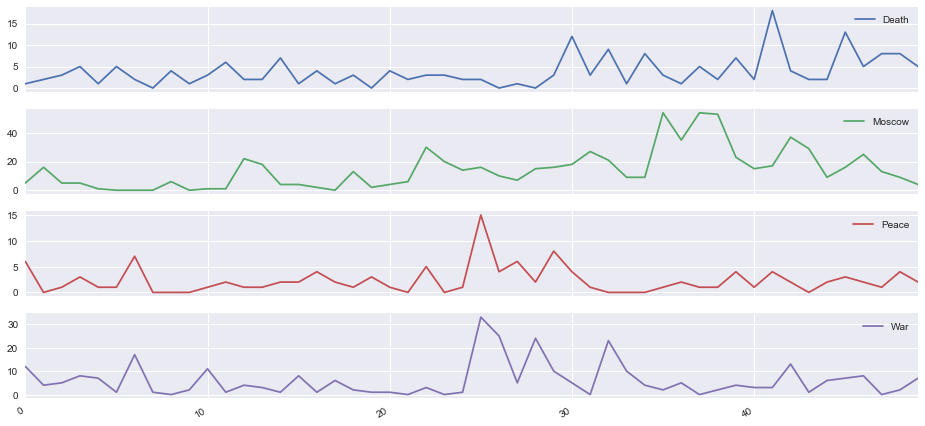

In [58]:
rcParams['figure.figsize'] = 16, 8

pd.DataFrame(
    {name: locations(name.lower(), war_peace) 
     for name in ['Moscow', 'War', 'Peace', 'Death']}
).plot(subplots=True)

# Exploring Named Entities

Named entities can be accessed through `doc.ents`. Let's find all the types of named entities from _Monty Python and the Holy Grail_: 

In [59]:
set([w.label_ for w in war_peace.ents])

{'CARDINAL',
 'DATE',
 'EVENT',
 'FAC',
 'GPE',
 'LANGUAGE',
 'LAW',
 'LOC',
 'MONEY',
 'NORP',
 'ORDINAL',
 'ORG',
 'PERCENT',
 'PERSON',
 'PRODUCT',
 'QUANTITY',
 'TIME',
 'WORK_OF_ART'}

<h2>What about those that are works of art?</h2>

In [60]:
[ent for ent in war_peace.ents if ent.label_ == 'WORK_OF_ART']

[
 the, 
 the sky,, 
 Life Guards, 
 Anna Pávlovna’s, Dear Countess, 
 on, 
 for, Foot Guards, 
 the, Catherine the Great, 
 man, 
 the, 
 the Archduke Ferdinand, 
 the way, 
 of, 
 the, Hurrah for the Austrians, 
 the Enns and the, 
 the, 
 the Grand Cross of Maria Theresa, 
 the, 
 the, 
 the, 
 man, 
 the French, 
 the, 
 the, 
 the, 
 the Bedchamber, Kuzmích..., “Thought... Blackguards..., 
 the, Fr... fr..., 
 the, 
 the, 
 the, 
 the, 
 on, 
 the French, ’s the Grand Duke, Kill the Germans, 
 the Tsar, 
 the dam,, Sónya on the sly, 
 the Frenchman Langeron,, 
    Have we not Bagratión, 
 and Dólokhov’s, 
 the, 
 the Rostóvs, 
 the, ’s peculiarities, 
 the, 
 the, 
 the Whole, 
 the Holy Virgin Mother of God.’..., Alësha the Sly, 
 the Tsar and, 
 the, 
 the, 
 the, 
 the, 
 the, 
 the Rostóvs, 
 the Emperor, 
 the Panins, 
 the, Came a, 
 
     As, 
 the, The Water-Carrier, 
 the, the Russian Note, The Duke of Oldenburg, 
 the Note, 
 the, 
 
     Aliment de poison, 
      Thou, 

<h2>Place names?</h2>

In [65]:
[ent for ent in war_peace.ents if ent.label_ == 'GPE']

[Genoa,
 Lucca,
 St. Petersburg,
 Schérer,
 Austria,
 Austria,
 Russia,
 England,
 Malta,
 Vienna,
 Empress,
 Petersburg,
 Petersburg,
 ,
 
 French,
 Prince Vasíli,
 Moscow,
 Russia,
 Petersburg,
 ,
 
 the,
 Mortemart,
 Hélène,
 Prince Hippolyte,
 
 a dark-,
 Paris,
 ,
 Russia,
 Buonaparte,
 Petersburg,
 Russia,
 
 Petersburg,
 ,
 Moscow,
 Vasíli,
 Lucca,
 Russia,
 Bâton de,
 France,
 heaven,
 Pierre,
 
 a,
 Arcola,
 Moscow,
 Russia,
 Moscow,
 Princesse,
 Prince Hippolyte,
 Hippolyte,
 Prince Andrew,
 Moscow,
 Petersburg,
 Prince Vasíli,
 England,
 Austria,
 
 the,
 Hippolyte,
 Mon Dieu,
 Prince Andrew,
 Kurágin,
 Kurágin,
 Dólokhov,
 Petersburg,
 ,
 Dólokhov’s,
 Dólokhov,
 Borís,
 Moscow,
 Petersburg,
 
 Moscow,
 Radzivílov,
 Moscow,
 ,
 ,
 ,
 ,
 Petersburg,
 Moscow,
 Petersburg,
 Dólokhov,
 Moscow,
 ,
 ,
 
 the Emperor,
 
 Petersburg,
 Moscow,
 
 the,
 ,
 Natásha,
 Natásha,
 Natásha,
 Sónya,
 Emperor,
 Sónya,
 ,
 Petersburg,
 Salomoni,
 Borís,
 Véra,
 Natásha,
 Sónya,
 Sónya,
 ,
 
 P

<h2>Organizations?</h2>

In [66]:
set(list([ent.string.strip() for ent in war_peace.ents if ent.label_ == 'ORG']))

{'',
 '1.B. “Project Gutenberg',
 '1.C. The Project Gutenberg',
 '3rd Corps',
 '8th Corps',
 'A Rhipheus',
 'ABC',
 'Academy',
 'Achilles',
 'Adjutant General Balashëv',
 'Adjutant General Wintzingerode',
 'Adjutant General Wolzogen',
 'Adjutant-General',
 'Agraféna\nIvánovna',
 'Agraféna Ivánovna Belóva',
 'Agraféna Ivánovna’s',
 'Akhárovs’',
 'Alexander',
 'Alexander, Elisaveta',
 'Alexanders',
 'Alexander’s',
 'Alexéy Petróvich',
 'Alley',
 'Allied',
 'Allies',
 'Alpátych',
 'Alpátych’s',
 'Amalek',
 'Anatole',
 'Anatole,',
 'Anna Mikháylovna',
 'Anna Pávlovna',
 'Anna Pávlovna’s',
 'Anna Schérer’s',
 'Anna Semënovna’s',
 'Antichrist',
 'Anísya',
 'Anísya Fëdorovna',
 'Anísya Fëdorovna’s',
 'Arakchéev',
 'Arakchéev’s',
 'Archive Foundation\n\nProject',
 'Aristóvo',
 'Armfeldt',
 'Army',
 'Asleep',
 'August a',
 'Auntie',
 'Austerlitz',
 'Austrian Council of War',
 'Bagratión',
 'Bagratión’s',
 'Balagá',
 'Balashëv',
 'Balashëv’s',
 'Bald\nHills',
 'Bald Hills',
 'Barclay',
 'Barclay

<h2>How about groups of people?</h2>

In [69]:
set([ent.string for ent in war_peace.ents if ent.label_ == 'NORP'])

{'\n',
 '\nBaltic ',
 '\nBourbons',
 '\nEuropean ',
 '\nFrench ',
 '\nGerman',
 '\nGerman ',
 '\nGermans',
 '\nMoscow ',
 '\nPrince Bolkónski’s ',
 '\nRussia',
 '\nRussian ',
 '\nRussians',
 '\nRussians ',
 '\nTurks ',
 '\na ',
 '\nthe Austrians',
 '\nthe Russian ',
 '\nthe tipsy guests who were again ',
 'Africans',
 'Allies',
 'Allies ',
 'Alsatian ',
 'Arab',
 'Arab ',
 'Arakchéev ',
 'Armenian ',
 'Armenians ',
 'Asiatic ',
 'Attempted ',
 'Austrian',
 'Austrian ',
 'Austrians',
 'Austrians ',
 'Bavarians',
 'Bedouin ',
 'Belgians',
 'Bells ',
 'Bohemian',
 'Bohemian ',
 'Bonapartist ',
 'Borodinó ',
 'Bourbons',
 'Bourbons ',
 'Bushes ',
 'Catholic ',
 'Central\nEurope',
 'Chinese',
 'Chinese ',
 'Christ',
 'Christian',
 'Christian ',
 'Christians',
 'Christians ',
 'Circassian',
 'Circassian ',
 'Crimean ',
 'Czech ',
 'Danish ',
 'Denísov ',
 'Dutch',
 'Dutch ',
 'Egyptian ',
 'Egyptians ',
 'English ',
 'European',
 'European ',
 'Finnish ',
 'French',
 'French ',
 'Frenchman',

<h2>"French" here refers to French _people_, not the French language. We can verify that by getting all the sentences in which this particular type of entity occurs:</h2>

In [71]:
russianPeople = [ent for ent in war_peace.ents if ent.label_ == 'NORP' and ent.string.strip() == 'Russian']
[ent.sent for ent in russianPeople]
#[ent.sent for ent in frenchPeople]

[At that moment Anna Pávlovna came up and, looking severely at Pierre,
 asked the Italian how he stood Russian climate.,
 I must tell it in Russian or the point will be
 lost....”,
 And Prince Hippolyte began to tell his story in such Russian
 as a Frenchman would speak after spending about a year in Russia.,
 And you were
 saying that the Russian ladies are not equal to the French?,
 As
 soon as he had seen a visitor off he returned to one of those who were
 still in the drawing room, drew a chair toward him or her, and jauntily
 spreading out his legs and putting his hands on his knees with the air
 of a man who enjoys life and knows how to live, he swayed to and
 fro with dignity, offered surmises about the weather, or touched on
 questions of health, sometimes in Russian and sometimes in very bad but
 self-confident French; then again, like a man weary but unflinching in
 the fulfillment of duty, he rose to see some visitors off and, stroking
 his scanty gray hairs over his bald pa

<h2>Parts of Speech</h2>

<h3>Each word already has a part of speech and a tag associated with it. Here's a list of all the parts of speech in _Pride and Prejudice_:<h3>

In [72]:
# Make a quick-and-dirty lookup table of POS IDs, 
# since the default representation of a POS is numeric. 
tagDict = {w.pos: w.pos_ for w in war_peace} 
tagDict

{82: 'ADJ',
 83: 'ADP',
 84: 'ADV',
 87: 'CCONJ',
 88: 'DET',
 89: 'INTJ',
 90: 'NOUN',
 91: 'NUM',
 92: 'PART',
 93: 'PRON',
 94: 'PROPN',
 95: 'PUNCT',
 97: 'SYM',
 98: 'VERB',
 99: 'X',
 101: 'SPACE'}

<h2>It's fun to compare the distribution of parts of speech in each text:</h2>

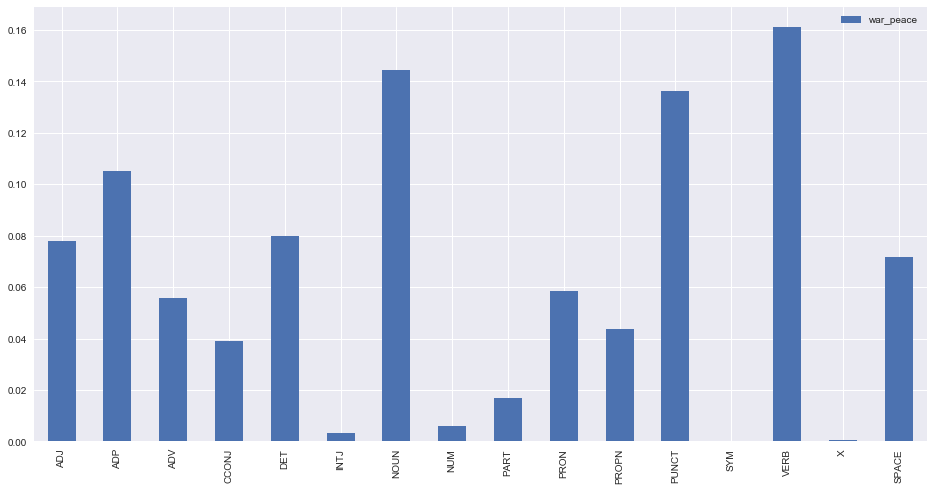

In [76]:
warPeacePOS = pd.Series(war_peace.count_by(spacy.attrs.POS))/len(war_peace)
#pridePOS = pd.Series(pride.count_by(spacy.attrs.POS))/len(pride)

rcParams['figure.figsize'] = 16, 8
df = pd.DataFrame([warPeacePOS], index=['war_peace'])
df.columns = [tagDict[column] for column in df.columns]
df.T.plot(kind='bar')

<h2>Now we can see, for instance, what the most common pronouns might be:</h2>

In [81]:
war_peace_ = [w for w in war_peace if w.is_stop == False]
warPeaceAdjs = [w for w in war_peace_ if w.pos_ == 'NOUN']
Counter([w.string.strip() for w in warPeaceAdjs]).most_common(10)

[('man', 1180),
 ('time', 924),
 ('face', 881),
 ('eyes', 826),
 ('men', 780),
 ('room', 770),
 ('army', 657),
 ('life', 608),
 ('head', 564),
 ('day', 562)]

In [82]:
warPeaceAdjs = [w for w in war_peace if w.pos_ == 'NOUN']
Counter([w.string.strip() for w in warPeaceAdjs]).most_common(10)

[('who', 2081),
 ('what', 1643),
 ('man', 1180),
 ('time', 924),
 ('face', 881),
 ('eyes', 826),
 ('men', 780),
 ('room', 770),
 ('army', 657),
 ('What', 642)]

<h2>Let's try this on the level of a sentence. First, let's get all the sentences in which Sir Robin is explicitly mentioned:</h2>

In [104]:
tsarSents = [sent for sent in war_peace.sents if 'Tsar' in sent.string]
tsarSents

[She felt, as courtiers do when the Tsar enters, the
 sensation of fear and respect which the old man inspired in all around
 him., It would not be turned off the field even on the Tsarítsin
 Meadow.”
 , “Don’t you understand that either we are officers
 serving our Tsar and our country, rejoicing in the successes and
 grieving at the misfortunes of our common cause, or we are merely
 lackeys who care nothing for their master’s business., ”
 
 “If I were Tsar I would never go to war,” said Nesvítski, turning
 away.
 , You see it’s hurrah for the Tsar,
 for Russia, for the Orthodox Greek faith!, So, my dear boy, you wish to serve the
 Tsar and the country?, And the Tsarévich was very gracious to all
 our officers.”
 , (“Arnauts” was the Tsarévich’s favorite expression when he was in
 a rage) and called for the company commander.
 
 “, Having been sent
 with papers from Kutúzov to the Tsarévich, he looked in on Borís,
 hoping to find him alone., The two Emperors,
 the Russian with his he

<h2>Now let's analyze just one of these sentences.</h2>

In [89]:
r2 = tsarSents[2]
r2

“Don’t you understand that either we are officers
serving our Tsar and our country, rejoicing in the successes and
grieving at the misfortunes of our common cause, or we are merely
lackeys who care nothing for their master’s business.

<h2>Let's look at the tags and parts of speech:</h2>

In [90]:
for word in r2: 
    print(word, word.tag_, word.pos_)

“ NFP PUNCT
Do VBP VERB
n’t NFP PUNCT
you PRP PRON
understand VBP VERB
that IN ADP
either CC CCONJ
we PRP PRON
are VBP VERB
officers NNS NOUN

 SP SPACE
serving VBG VERB
our PRP$ ADJ
Tsar NNP PROPN
and CC CCONJ
our PRP$ ADJ
country NN NOUN
, , PUNCT
rejoicing VBG VERB
in IN ADP
the DT DET
successes NNS NOUN
and CC CCONJ

 SP SPACE
grieving VBG VERB
at IN ADP
the DT DET
misfortunes NNS NOUN
of IN ADP
our PRP$ ADJ
common JJ ADJ
cause NN NOUN
, , PUNCT
or CC CCONJ
we PRP PRON
are VBP VERB
merely RB ADV

 SP SPACE
lackeys NNS NOUN
who WP NOUN
care VBP VERB
nothing NN NOUN
for IN ADP
their PRP$ ADJ
master NN NOUN
’s CD NUM
business NN NOUN
. . PUNCT


# Dependency Parsing
Now let's analyze the structure of the sentence. 

<h2>This sentence has lots of properties:</h2>

In [92]:
[prop for prop in dir(r2) if not prop.startswith('_')]

['doc',
 'end',
 'end_char',
 'ent_id',
 'ent_id_',
 'has_vector',
 'label',
 'label_',
 'lefts',
 'lemma_',
 'lower_',
 'merge',
 'noun_chunks',
 'orth_',
 'rights',
 'root',
 'sent',
 'sentiment',
 'similarity',
 'start',
 'start_char',
 'string',
 'subtree',
 'text',
 'text_with_ws',
 'upper_',
 'vector',
 'vector_norm']

<h2>To drill down into the sentence, we can start with the root:</h2>

In [93]:
r2.root

understand

<h2>That root has children:</h2>

In [94]:
list(r2.root.children)

[“, Do, you, are, .]

<h2>Let's see all of the children for each word:</h2>

In [95]:
for word in r2: 
    print(word, ': ', str(list(word.children)))

“ :  []
Do :  [n’t]
n’t :  []
you :  []
understand :  [“, Do, you, are, .]
that :  []
either :  []
we :  []
are :  [that, either, we, officers]
officers :  [
, serving]

 :  []
serving :  [Tsar, rejoicing]
our :  []
Tsar :  [our, and, country]
and :  []
our :  []
country :  [our, ,]
, :  []
rejoicing :  [in, ,, or, are]
in :  [successes]
the :  []
successes :  [the, and, grieving]
and :  [
]

 :  []
grieving :  [at]
at :  [misfortunes]
the :  []
misfortunes :  [the, of]
of :  [cause]
our :  []
common :  []
cause :  [our, common]
, :  []
or :  []
we :  []
are :  [we, merely, lackeys]
merely :  [
]

 :  []
lackeys :  [care]
who :  []
care :  [who, nothing]
nothing :  [for]
for :  [business]
their :  []
master :  [’s]
’s :  []
business :  [their, master]
. :  []


<h2>Since adjectives are typically children of the things they describe, we can get approximations for adjectives that describe characters. How is Sir Robin described?</h2>

In [105]:
for sent in tsarSents: 
    for word in sent: 
        if 'Tsar' in word.string: 
            for child in word.children: 
                if child.pos_ == 'ADJ':
                    print(child)

our
his
their
his
their


<h2>Now let's do something similar for Pride and Prejudice. First, we'll use named entity extraction to get a list of the most frequently mentioned characters:</h2>

In [106]:
Counter([w.string.strip() for w in war_peace.ents if w.label_ == 'PERSON']).most_common(10)

[('Pierre', 1770),
 ('Prince Andrew', 594),
 ('Nicholas', 532),
 ('Natásha', 454),
 ('Rostóv', 428),
 ('Princess Mary', 387),
 ('Napoleon', 371),
 ('Andrew', 324),
 ('Kutúzov', 300),
 ('Denísov', 267)]

<h2>Now we can write a function that walks down the tree from each character, looking for the first adjectives it can find:</h2>

In [109]:
def adjectivesDescribingCharacters(text, character):
    sents = [sent for sent in text.sents if character in sent.string]
    adjectives = []
    for sent in sents: 
        for word in sent: 
            if character in word.string:
                for child in word.children: 
                    if child.pos_ == 'ADJ': 
                        adjectives.append(child.string.strip())
    return Counter(adjectives).most_common(10)

<h2>We'll try it on Mr. Darcy:</h2>

In [115]:
adjectivesDescribingCharacters(war_peace, 'Pierre')

[('my', 3),
 ('dear', 3),
 ('amazed', 2),
 ('plain', 1),
 ('surprised', 1),
 ('different', 1),
 ('good', 1),
 ('gentle', 1),
 ('fifth', 1),
 ('impressed', 1)]

<h2>Now let's do the same sort of thing, but look for associated verbs. First, let's get all the sentences in which Elizabeth is mentioned:</h2>

In [116]:
NapoleonSentences = [sent for sent in war_peace.sents if 'Napoleon' in sent.string]

In [117]:
NapoleonSentences[3]

I say so,” he continued desperately, “because the Bourbons fled
from the Revolution leaving the people to anarchy, and Napoleon alone
understood the Revolution and quelled it, and so for the general good,
he could not stop short for the sake of one man’s life.

<h3>We want the verb associated with Elizabeth, _remained_, not the root verb of the sentence, _walked_, which is associated with Mr. Darcy. So let's write a function that will walk up the dependency tree from a character's name until we get to the first verb. 

We'll use lemmas instead of the conjugated forms to collapse _remain_, _remains_, and _remained_ into one verb: _remain_.</h3>

In [118]:
def verbsForCharacters(text, character):
    sents = [sent for sent in text.sents if character in sent.string]
    charWords = []
    for sent in sents: 
        for word in sent: 
            if character in word.string: 
                charWords.append(word)
    charAdjectives = []
    for word in charWords: 
        # Start walking up the list of ancestors 
        # Until we get to the first verb. 
        for ancestor in word.ancestors: 
            if ancestor.pos_.startswith('V'): 
                charAdjectives.append(ancestor.lemma_.strip())
    return Counter(charAdjectives).most_common(20)

In [119]:
NapoleonVerbs = verbsForCharacters(war_peace, 'Napoleon')
NapoleonVerbs

[('be', 200),
 ('say', 67),
 ('seem', 26),
 ('know', 22),
 ('have', 21),
 ('give', 20),
 ('see', 19),
 ('do', 19),
 ('go', 16),
 ('make', 16),
 ('ride', 14),
 ('ask', 13),
 ('take', 13),
 ('turn', 13),
 ('come', 12),
 ('look', 11),
 ('notice', 10),
 ('speak', 10),
 ('tell', 10),
 ('order', 10)]

In [121]:
PierreVerbs = verbsForCharacters(war_peace, 'Pierre')
PierreVerbs
#janeVerbs = verbsForCharacters(pride, 'Jane')
#janeVerbs

[('be', 304),
 ('say', 228),
 ('look', 114),
 ('see', 82),
 ('go', 81),
 ('ask', 69),
 ('take', 65),
 ('feel', 65),
 ('come', 62),
 ('think', 61),
 ('know', 58),
 ('have', 49),
 ('begin', 44),
 ('tell', 41),
 ('sit', 41),
 ('turn', 40),
 ('seem', 36),
 ('reply', 33),
 ('notice', 32),
 ('give', 27)]

<h2>Now merge these counts into a single table, and then visualize it with Pandas.</h2>

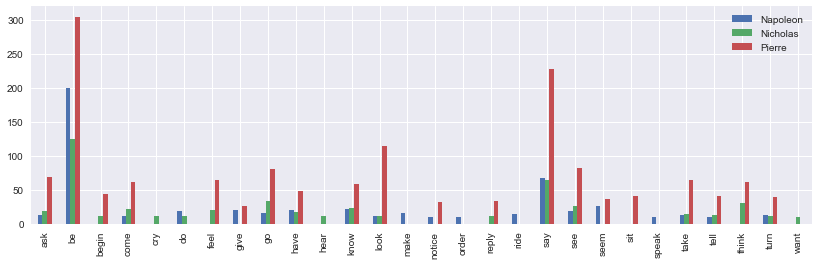

In [123]:
def verbsToMatrix(verbCounts): 
    """ 
    Takes verb counts given by verbsForCharacters 
    and makes Pandas Series out of them, suitabe for combination in 
    a DataFrame. 
    """
    return pd.Series({t[0]: t[1] for t in verbCounts})

verbsDF = pd.DataFrame({'Napoleon': verbsToMatrix(NapoleonVerbs), 
                        'Pierre': verbsToMatrix(PierreVerbs), 
                        'Nicholas': verbsToMatrix(verbsForCharacters(war_peace, 'Nicholas'))}).fillna(0)
verbsDF.plot(kind='bar', figsize=(14,4));

# Probabilities

SpaCy has a list of probabilities for English words, and these probabilities are automatically associated with each word once we parse the document. Let's see what the distribution is like: 

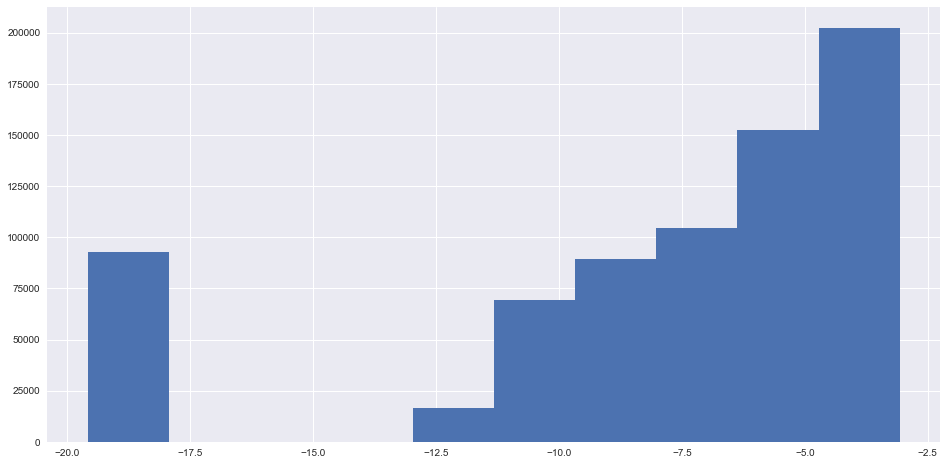

In [126]:
probabilities = [word.prob for word in war_peace] 
pd.Series(probabilities).hist();

<h2>Let's look at some of the improbable words for _Monty Python and the Holy Grail_.</h2>

In [127]:
#the only thing is that the prob of each word is from the dictionary itself so it doesn't represent the probability 
#of the word in relation to the text itself. not really useful imo


list(set([word.string.strip().lower() for word in war_peace if word.prob < -19]))[:20]

['',
 'akhrosímova',
 'blessedness',
 'adroit',
 'mornings',
 'rabble',
 'scenery',
 'grunt',
 'criterion',
 'excludes',
 'moskowa',
 'carelessness',
 'slackened',
 'wearisome',
 'kaftáns',
 'conducing',
 'vive',
 'sacredness',
 'crude',
 'owner']

<h2>Now we can do some rudimentary information extraction by counting the improbable words:</h2>

In [128]:
Counter([word.string.strip().lower() 
         for word in war_peace 
         if word.prob < -19.5]).most_common(20)

[('pierre', 1963),
 ('prince', 1927),
 ('natásha', 1211),
 ('andrew', 1140),
 ('n’t', 1108),
 ('princess', 882),
 ('rostóv', 776),
 ('chapter', 730),
 ('moscow', 720),
 ('emperor', 629),
 ('nicholas', 600),
 ('napoleon', 578),
 ('kutúzov', 529),
 ('', 491),
 ('countess', 451),
 ('sónya', 447),
 ('denísov', 430),
 ('’ll', 375),
 ('evidently', 350),
 ('dólokhov', 328)]

<h2>What are those words for _Grail_?</h2>

In [134]:
Counter([word.string.strip().lower() 
         for word in grail 
         if word.prob < -19.5 
         and word.is_alpha
         and word.pos_ != 'PROPN'] # This time, let's ignore proper nouns.
       ).most_common(20)

[('arthur', 157),
 ('father', 54),
 ('villager', 47),
 ('bedevere', 44),
 ('galahad', 43),
 ('knights', 34),
 ('burn', 32),
 ('guard', 32),
 ('mumble', 30),
 ('squeak', 29),
 ('clop', 26),
 ('head', 25),
 ('soldier', 24),
 ('herbert', 20),
 ('launcelot', 19),
 ('castle', 18),
 ('zoot', 18),
 ('guests', 18),
 ('clang', 17),
 ('crowd', 17)]

<h2>We can do this with ngrams, too, with some fancy Python magic:</h2>

In [135]:
def ngrams(doc, n): 
    doc = [word for word in doc 
           if word.is_alpha # Get rid of punctuation
           if not word.string.isupper()] # Get rid of all-caps speaker headings
    return list(zip(*[doc[i:] for i in range(n)]))

In [136]:
grailGrams = set(ngrams(grail, 3))
warPeaceGrams = set(ngrams(war_peace,3))

In [133]:
for gram in warPeaceGrams: 
    if sum([word.prob for word in gram]) < -40: 
        print(gram)

(roaring, and, snapping)
(and, Mademoiselle, Bourienne)
(clattering, chains, stepped)
(memories, suddenly, arose)
(same, misty, darkness)
(frère, Yesterday, learned)
(eyelids, drooped, The)
(particularly, struck, Pierre)
(Stepán, Stepánych, also)
(sleepy, indifference, suddenly)
(the, invincible, Napoleon)
(hay, Alpátych, went)
(chase, Daniel, hearing)
(naturedly, to, Rostóv)
(whistle, flew, over)
(Natásha, raising, herself)
(dozed, off, Alpátych)
(his, borzoi, Karáy)
(Prince, Andrew, scanned)
(Dress, your, ranks)
(Nicholas, clearing, his)
(And, Platón, Karatáev)
(Shcherbínin, youthful, face)
(an, irregularly, swaying)
(Mademoiselle, Bourienne, how)
(and, Corps, sixteen)
(angrily, avoiding, Pierre)
(to, clench, Nicholas)
(to, bleed, Denísov)
(unhappily, and, greedily)
(favorite, barcarolle, Natásha)
(this, Moscow, Bordeaux)
(wrote, La, mort)
(masculine, odor, and)
(policeman, astride, a)
(Major, Denísov, Rostóv)
(by, cavalry, scouting)
(rebuild, in, Moscow)
(The, cavalry, singers)
(Den

(morning, Anna, Mikháylovna)
(Sónya, presided, beside)
(trim, wearing, shakos)
(abundance, of, provisions)
(when, Prince, Andrew)
(thought, Platón, Karatáev)
(noticed, Balashëv, embarrassment)
(go, cried, Anatole)
(greeted, him, gaily)
(Kuzmích, the, laughter)
(saddle, Chekmár, held)
(not, contradict, Willarski)
(le, trip, ta)
(cried, Prince, Andrew)
(by, monarchs, ministers)
(Pratzen, constituted, the)
(Augesd, Dam, where)
(Prince, Vasíli, had)
(culprit, was, Alexander)
(his, Serene, Highness)
(bee, collect, pollen)
(mindedness, kept, rubbing)
(Bourbons, plainly, assert)
(senior, artillery, officer)
(Pierre, glanced, at)
(assurance, of, Napoleon)
(his, mustaches, extending)
(passionately, angry, glance)
(Often, after, collecting)
(poetic, and, mystic)
(husband, dressing, gowns)
(laughter, and, merry)
(à, la, française)
(suite, galloped, off)
(soles, and, palms)
(Bilíbin, smiled, and)
(speaking, Prince, Andrew)
(something, senseless, masculine)
(replied, Pierre, Half)
(rubs, the, bump)

(and, ermine, cautiously)
(man, scrutinizing, Anatole)
(rations, the, commissariat)
(astonished, narrator, shrugging)
(red, haired, Deméntyev)
(tipsy, officers, tossed)
(shadows, Bang, bang)
(and, clapping, Rostóv)
(said, Márya, Dmítrievna)
(will, whispered, Natásha)
(with, pale, swollen)
(of, feminine, charm)
(rubbish, larvae, and)
(back, shouted, Dólokhov)
(and, artillery, horses)
(velocity, through, immeasurable)
(restrained, animation, as)
(tendre, ma, pauvre)
(was, concluded, Pierre)
(the, esaul, conveying)
(raft, Prince, Andrew)
(said, Márya, Dmítrievna)
(stumbled, on, Bagovút)
(lower, jaw, trembled)
(foresees, all, contingencies)
(Mademoiselle, Bourienne, Mary)
(Maude, Posting, Date)
(Little, Túshin, moving)
(in, Carriage, Row)
(eternally, predetermined, and)
(Emperor, Napoleon, had)
(squadron, replied, Repnín)
(enter, Prince, Andrew)
(princess, His, disillusionments)
(with, Raévski, tender)
(The, battalions, shouted)
(his, foe, waved)
(midnight, Bolkhovítinov, having)
(robbing,

(Smolénsk, highroad, During)
(unexpectedly, Bennigsen, did)
(whist, and, boston)
(with, merry, chatter)
(drew, Pierre, irresistibly)
(Vílna, province, offered)
(Der, alte, Herr)
(agitated, and, tormented)
(Andrew, Alpátych, turned)
(smilingly, expressed, disapproval)
(Lopukhín, and, Kochubéy)
(adjutant, galloped, up)
(Prince, Andrew, entered)
(winced, and, clutching)
(Michael, Ivánovich, Michael)
(Andrew, of, Natásha)
(prison, Count, Rostopchín)
(then, sa, pauvre)
(grief, that, weighed)
(Prince, Andrew, shrugged)
(ringing, deliberate, voice)
(Anna, Mikháylovna, to)
(General, Prince, Volkónski)
(noiseless, steps, lifted)
(smoothing, her, gown)
(of, Pierre, sleigh)
(promised, land, Coming)
(enrollment, of, recruits)
(dear, Monsieur, Pierre)
(repeated, Prince, Andrew)
(littered, with, wisps)
(villain, Mítenka, flew)
(loudly, and, gesticulating)
(the, deepest, reflections)
(aged, stern, motionless)
(The, countess, reflected)
(Andrew, sighed, and)
(the, businesslike, preoccupied)
(premises,

(large, guerrilla, detachment)
(resigned, his, commission)
(galloped, twenty, miles)
(vodka, he, drank)
(glanced, at, Prince)
(frightened, yet, resolute)
(how, Prince, Andrew)
(twenty, fifth, Barclay)
(Niemen, awaiting, Napoleon)
(the, Grand, Master)
(seeker, for, entrance)
(Prince, Andrew, The)
(harp, Wafting, sweet)
(capitulation, and, meanwhile)
(Dunyásha, protests, she)
(doctor, Larrey, examine)
(enormous, popular, tide)
(to, Napoleon, Balashëv)
(Pierre, was, delighted)
(The, princess, blushed)
(a, corps, commander)
(and, aristocratic, baritone)
(officers, gathered, round)
(what, inquired, Pierre)
(to, Natásha, sleigh)
(one, Dearest, Princess)
(Sónya, How, plainly)
(himself, comfortably, clasped)
(the, corridor, Euer)
(After, supper, Nicholas)
(camp, Bonaparte, riding)
(Pétya, sobbed, and)
(flashed, through, Sónya)
(Prussians, Saxons, Poles)
(died, Prince, Andrew)
(water, joyfully, wriggling)
(plain, forage, cap)
(the, august, melancholy)
(avec, ce, jeune)
(Pierre, Your, grenadiers

(Andrew, coldly, and)
(the, Emperor, displeasure)
(wives, or, husbands)
(Emperor, munching, a)
(French, proverb, deliberately)
(retreat, from, Vílna)
(Anna, Pávlovna, Rousseau)
(absent, mindedly, Go)
(sagacious, Barclay, de)
(nothingness, and, immeasurable)
(et, faites, pas)
(Vilkavisski, forest, Old)
(the, Shevárdino, Redoubt)
(Andrew, rose, and)
(Eh, Dron, drop)
(bast, shoes, ran)
(Julie, Karágina, to)
(inflamed, and, streaming)
(Some, forty, Uhlans)
(satisfying, his, passions)
(historic, significance, The)
(appointment, as, Commander)
(to, Napoleon, Pierre)
(deft, circular, motions)
(loved, Prince, Andrew)
(Frenchmen, stark, with)
(perfect, stillness, Pierre)
(unbrushed, tufts, of)
(Prince, Volkónski, as)
(eyes, Adorable, divine)
(Prince, Andrew, smiled)
(words, Sergéy, Kuzmích)
(carved, garden, fence)
(Mikháylovna, paused, and)
(gossips, said, Dólokhov)
(vous, manger, pas)
(cried, Vereshchágin, in)
(the, corps, Recite)
(gorges, The, turrets)
(conceal, its, sunken)
(Pierre, or, Prin

(Prince, Andrew, engagement)
(priests, and, icons)
(Treasury, cautiously, ventured)
(Arakchéev, and, tutti)
(herd, of, cattle)
(calamities, of, Moscow)
(after, collecting, alms)
(Princess, Mary, presence)
(to, Rostóv, renewed)
(of, approbation, Schubert)
(repentance, and, ecstasy)
(anxiously, noting, every)
(said, Prince, Andrew)
(storm, Rostóv, looked)
(Natásha, undress, darling)
(passing, battalions, Seeing)
(Pétya, found, Denísov)
(Anatole, following, Natásha)
(him, Prince, Andrew)
(the, millpool, Turn)
(hempen, rags, from)
(Pierre, was, kissed)
(ballroom, waited, till)
(dictated, the, dispositions)
(own, accord, Toward)
(diary, Nicholas, repeated)
(a, transportée, des)
(Lieutenant, Colonel, Denísov)
(Natásha, gazed, at)
(and, glancing, wrathfully)
(the, prince, estates)
(your, slut, Aide)
(awaiting, Pétya, return)
(spitting, blood, bullet)
(was, Anatole, Kurágin)
(Serene, Highness, had)
(the, ranks, morose)
(gradually, compelled, her)
(or, Dron, Dunyásha)
(Duc, declared, Monsieur)


(idle, and, frivolous)
(smiling, Mademoiselle, Bourienne)
(hoarse, with, hallooing)
(to, Nicholas, Pray)
(window, sill, leaned)
(next, knuckle, whispering)
(fall, Prince, Andrew)
(vient, à, point)
(our, epoch, histories)
(the, artillery, commander)
(campfires, while, carriages)
(and, gazed, intently)
(village, of, Schön)
(was, awaiting, Pétya)
(Brothers, Joseph, Alexéevich)
(be, agitated, Nicholas)
(honorably, said, Napoleon)
(duels, thereby, proving)
(stiffness, accompanied, her)
(courteously, in, token)
(Andrew, smiled, do)
(Moscow, acquaintances, It)
(long, mustaches, extending)
(fingerboard, arching, his)
(Ilyín, mo, o)
(Gracious, heavens, Lord)
(the, splendid, countess)
(Telyánin, Telyánin, was)
(wax, taper, in)
(Project, Gutenberg, tm)
(frowned, shrugged, his)
(at, Bald, Hills)
(favor, revolutions, overthrow)
(with, hors, Speránski)
(hussars, and, willingly)
(de, vous, voir)
(ankles, for, warmth)
(And, Natásha, kissed)
(shrieking, floundered, about)
(Thirty, thousand, devils)
(sw

(Prince, Andrew, relapsing)
(pace, Lads, shouted)
(Vesénny, vernal, and)
(distinguished, and, wealthier)
(quietly, remarked, the)
(said, Prince, Andrew)
(dug, clay, of)
(seeming, disagreements, and)
(his, squadron, quartermaster)
(to, inquired, Denísov)
(and, prayers, Princess)
(French, infantry, soldiers)
(other, refuge, Julie)
(the, prospective, purchaser)
(proposals, Pfuel, alone)
(broad, cheekbones, sunken)
(warmed, and, fragrant)
(pervaded, the, Rostóv)
(deputation, had, begun)
(them, Prince, Andrew)
(Mítenka, himself, returning)
(booming, of, cannon)
(to, Mávra, Kuzmínichna)
(bushes, he, glanced)
(Elder, peasant, women)
(Project, Gutenberg, associated)
(worldliness, and, senselessness)
(decisive, and, solemn)
(replied, Pierre, Lord)
(Prince, Andrew, with)
(attributed, the, calamities)
(Au, revoir, Good)
(Prince, Bolkónski, was)
(Bennigsen, descended, the)
(Prince, Andrew, arrived)
(sachiez, que, une)
(dreadful, dreadful, she)
(Pierre, The, curly)
(such, aromatic, jam)
(Prince, An

(broad, reddish, hands)
(The, Emperor, thanked)
(good, humored, amiable)
(absent, mindedness, she)
(from, Márya, Dmítrievna)
(sat, erect, gazing)
(action, Specialist, historians)
(shaved, bwushed, my)
(Black, robber, bees)
(neighboring, smithy, hearing)
(continually, praising, Natásha)
(The, regimental, adjutant)
(concluded, his, evidently)
(return, Prince, Vasíli)
(indispensable, every, administrator)
(and, thirsty, shoots)
(milldam, and, forming)
(which, Napoleon, rode)
(crossbeam, tugged, and)
(to, descend, evenly)
(retreating, Lead, the)
(a, charming, Moscow)
(Prince, Vasíli, to)
(of, Chichagóv, Kutúzov)
(motionless, almost, lifeless)
(intimate, acquaintance, Anna)
(eldest, princess, Those)
(him, absent, mindedly)
(convalescence, Dólokhov, lay)
(wartime, by, commanders)
(oak, buds, unfold)
(Dmítrievna, broad, stern)
(dirty, barefooted, maid)
(gown, and, smiled)
(the, chairs, lightly)
(Plátov, to, retreat)
(and, ostentatiously, approached)
(the, Bourbons, plainly)
(dark, sea, swelli

(discredited, rulers, of)
(tramp, of, hoofs)
(lit, dining, room)
(Prince, Andrew, was)
(barefoot, and, worn)
(Unwilling, to, obtrude)
(solemn, and, awakening)
(the, Shevárdino, Redoubt)
(Davout, Ney, and)
(his, fur, cloak)
(Rostóv, grew, frightened)
(Hofkriegsrath, from, Vienna)
(gate, stood, Gerásim)
(first, promotion, Berg)
(and, persistently, gazed)
(bayonet, and, stabs)
(accents, Nicholas, understood)
(Mikháylovna, looked, attentively)
(assurance, of, possessing)
(bald, head, Véra)
(rubbed, his, forehead)
(outlawed, brigand, But)
(and, estranged, Pierre)
(institutions, thereby, combining)
(dressing, gown, his)
(He, flushed, crimson)
(columns, The, colonel)
(the, Archduke, Ferdinand)
(mounted, Frenchmen, probably)
(suis, homme, your)
(snow, Pierre, clutched)
(pallid, and, quivered)
(shouting, Hurrah, Kutúzov)
(arrival, The, lieutenant)
(he, shouted, bowing)
(faithful, ally, We)
(the, rulers, conditionally)
(corridor, Gerásim, and)
(Thy, beloved, Russia)
(plight, our, Anatole)
(overc

(Russian, army, retreated)
(ambled, smoothly, under)
(and, snorted, Fool)
(shed, On, August)
(Mademoiselle, Bourienne, smiling)
(Denísov, rose, asked)
(Moscow, asked, Princess)
(her, baseness, folly)
(rose, He, patted)
(ho, ho, Do)
(urging, Pierre, to)
(lemonade, and, Morel)
(large, gray, mustache)
(Mary, gazed, intently)
(Prince, Andrew, smiling)
(Prince, Andrew, Please)
(Kutúzov, interrupting, him)
(circle, Anna, Pávlovna)
(behind, Prince, Andrew)
(Hurrah, pursued, them)
(tighter, The, Frenchman)
(glum, asked, Nesvítski)
(there, Ermólov, wished)
(Andrew, ironical, tone)
(evenly, Prince, Andrew)
(and, condemned, Friant)
(Pelagéya, interrupted, her)
(him, Nicholas, Nicholas)
(reheat, the, samovar)
(risen, to, greet)
(correspondence, with, Petersburg)
(smiled, at, Pierre)
(floor, hoarsely, uttering)
(Vyázma, and, Tarútino)
(Natásha, You, shaking)
(Turkey, Sorrow, it)
(her, kerchief, torn)
(amid, the, crush)
(heightened, Pierre, pleasure)
(frowning, brows, was)
(report, skillfully, point

(harms, and, hinders)
(enhance, Véra, beauty)
(Prince, Andrew, And)
(be, Anatole, Sónya)
(nearer, and, nearer)
(Having, wept, talked)
(left, Prince, Vasíli)
(Prince, Vasíli, house)
(his, spurs, jingling)
(hounds, said, Uncle)
(a, frown, Borís)
(the, cannon, sketched)
(undertake, to, bweak)
(Princess, Mary, Dessalles)
(Captain, Túshin, Captain)
(capable, evidently, suffering)
(Two, huntsmen, galloped)
(Mademoiselle, Bourienne, Princess)
(orderly, jacket, and)
(of, Count, Bezúkhov)
(Sónya, muttering, to)
(Uhlans, Nearer, and)
(and, stretcher, bearers)
(Archive, Foundation, and)
(Russian, kaftáns, Powdered)
(vous, aime, et)
(needles, or, splinters)
(smiled, and, Pétya)
(sire, replied, Balashëv)
(smiling, If, Buonaparte)
(an, incomprehensible, supernatural)
(influenced, Alexander, Paulucci)
(face, Count, Rostóv)
(rode, hastily, away)
(vous, en, conjure)
(tête, de, pont)
(woods, Napoleon, agreed)
(the, countess, Natásha)
(Nicholas, Rostóv, awarded)
(fog, had, begun)
(get, Denísov, petition)

(Barclay, de, Tolly)
(carriage, wheels, rattled)
(Prince, Andrew, repeated)
(in, sixteen, paces)
(cheerful, as, befits)
(his, neglected, estates)
(Ramballe, captain, of)
(Princess, Mary, looked)
(observed, Anna, Pávlovna)
(tenderly, gazing, at)
(reply, Wine, Gluttony)
(the, impious, Bonaparte)
(vodka, Count, asked)
(to, Boguchárovo, Seventy)
(and, Anna, Mikháylovna)
(the, Emperor, Alexander)
(cuisse, de, nymphe)
(fatigue, perspiring, and)
(the, suite, Rostóv)
(hoarse, voice, Suddenly)
(mind, Prince, Andrew)
(wicked, triumph, How)
(dispatched, Adjutant, General)
(Involuntarily, recalling, his)
(Prince, Vasíli, servants)
(Dmítrievna, anteroom, the)
(captain, touchingly, recounted)
(gloomier, Gerásim, opened)
(June, Count, Zhilínski)
(do, exclaimed, Rostopchín)
(day, Prince, Vasíli)
(his, forehead, wetting)
(or, Platósha, chaffed)
(quenched, his, fires)
(peasant, militiamen, in)
(directing, her, wanderings)
(over, Lelorgne, smilingly)
(This, procrastinator, Kutúzov)
(noisily, flapping, th

(animation, and, determination)
(que, une, femme)
(master, arrived, Everywhere)
(gentle, Balashëv, found)
(promised, Prince, Anatole)
(Natásha, became, thoughtful)
(a, skillful, commander)
(anxious, inquiries, as)
(great, excitement, arising)
(Andrew, attentions, to)
(To, Pierre, inquiries)
(Gracious, Sovereign, and)
(examining, continuous, motion)
(dam, amid, the)
(prince, already, yielding)
(desperately, squeezed, together)
(orgies, and, debauchery)
(cheeks, quivered, and)
(Bonaparte, loose, knock)
(majestic, and, unexpected)
(buckwheat, The, wooded)
(Mikháylovna, and, dashing)
(serf, conscripted, instead)
(and, boundless, horizons)
(the, trunks, Heavens)
(fond, of, Rostóv)
(Emperor, displeasure, said)
(Napoleon, not, ridden)
(former, spirituous, fragrant)
(horses, splashing, through)
(continued, Prince, Andrew)
(the, foe, Napoleon)
(Alpátych, sternly, see)
(own, jealousy, recurred)
(premonition, was, disagreeable)
(the, melody, merged)
(dreadful, said, Pierre)
(triple, talent, De)
(

(Dólokhov, rode, to)
(as, waitresses, Rostóv)
(bright, blue, Sèvres)
(took, Vienna, Berlin)
(gently, smiling, with)
(Emperor, Balashëv, replied)
(Gérard, est, ici)
(again, Anísya, Fëdorovna)
(fuller, and, merging)
(accordingly, Ermólov, screwed)
(morose, paced, up)
(scattering, sparks, from)
(Bessières, Caulaincourt, and)
(contemptuously, respectful, attitude)
(of, Maria, Theresa)
(Andrew, wished, to)
(Bohemian, mountains, defending)
(Moscow, life, flowed)
(Pierre, became, silent)
(dishonorable, He, dishonorable)
(But, Prince, Andrew)
(seen, Kutúzov, shouted)
(dishonorable, Borís, made)
(Adieu, Prince, May)
(Mávra, Kuzmínichna, who)
(malheureux, Mack, he)
(Princess, Anna, Mikháylovna)
(cavalry, should, gallop)
(gentleman, he, hesitated)
(Rapp, Napoleon, looked)
(apron, and, waving)
(oaks, are, budding)
(groaning, and, loudly)
(le, triple, talent)
(here, amid, fieldwork)
(approached, Yaroslávl, the)
(without, prominently, displaying)
(Prince, Andrew, some)
(new, companions, crossing)
(w

(staff, officer, remained)
(Mademoiselle, Bourienne, was)
(satisfying, the, irresistible)
(delightful, Prince, Hippolyte)
(continued, Prince, Andrew)
(make, menacing, gestures)
(Has, Prince, Vasíli)
(or, wounded, horses)
(ma, chère, ma)
(Karp, and, seized)
(behind, Erzá, rushed)
(expiation, shouted, one)
(cried, noticing, the)
(Au, revoir, Beauché)
(Emperor, Suddenly, a)
(diplomatic, dispatch, which)
(five, acres, bloodstained)
(kinds, tradesmen, artisans)
(present, en, garçon)
(possible, exclaimed, Anna)
(strange, attire, appeared)
(the, monarch, mounted)
(sighed, and, shook)
(overtaken, the, regiment)
(vent, his, wrath)
(Emperor, Alexander, regime)
(hour, Mademoiselle, Bourienne)
(dowerless, Sónya, On)
(onlookers, who, jesting)
(be, melted, instantaneously)
(third, squadron, tossed)
(shrine, with, innumerable)
(speaking, Pierre, rubbed)
(dearest, Mummy, she)
(Count, Count, shouted)
(straighten, the, leash)
(with, parted, lips)
(low, tones, Prince)
(householders, seized, all)
(the, ch

(Guards, and, traversed)
(flask, of, rum)
(on, horseback, inspecting)
(Vereshchágin, Vereshchágin, he)
(the, adjutant, dismounted)
(Princess, Mary, entering)
(Pierre, The, princess)
(mort, est, secourable)
(with, meekly, downcast)
(the, Emperor, Toll)
(marshals, accompanied, by)
(Caulaincourt, for, appreciation)
(raised, Telyánin, handed)
(cloth, covered, sheepskin)
(first, gracious, reception)
(disarmed, Frenchmen, pass)
(Prince, Andrew, Oh)
(r, and, pronouncing)
(cavalry, captain, Kírsten)
(underneath, Here, exclaimed)
(said, Pétya, blushing)
(Natásha, and, Nicholas)
(Danube, marching, on)
(brother, Be, kindly)
(abandoning, Moscow, and)
(cher, he, remarked)
(the, Emperor, Alexander)
(brows, frowned, ever)
(Bilíbin, witticisms, were)
(Count, Rostopchín, with)
(the, fur, lined)
(incomprehensible, supernatural, significance)
(backbiter, said, Dolgorúkov)
(summoned, de, Beausset)
(unexpectedly, rapturous, and)
(Hurrah, and, resolved)
(triumphant, that, Pierre)
(trembles, is, unnerved)
(q

(the, outlying, quarters)
(Grand, Duke, in)
(infantry, officer, laughed)
(Father, feedeth, them)
(Prussians, The, Prussians)
(they, remained, inert)
(murmur, of, approbation)
(Makár, Alexéevich, was)
(returned, Pierre, Though)
(angrily, Dram, da)
(Prince, Andrew, took)
(to, Prince, Bagratión)
(muttering, angrily, came)
(Anna, Mikháylovna, blandly)
(happened, Anna, Pávlovna)
(called, cried, Nicholas)
(the, fourteenth, accompanied)
(thought, Rascals, Blackguards)
(at, Prince, Vasíli)
(Prince, Andrew, turned)
(dismissed, the, abbé)
(biscuits, fodder, and)
(princess, listened, smiling)
(dismay, and, seizing)
(being, Rapidly, leaping)
(Sónya, and, Natásha)
(radiant, eyes, gazed)
(Majesty, grieve, that)
(reception, Arakchéev, had)
(Magnítski, addressing, himself)
(that, Prince, Andrew)
(eyebrows, and, whiskers)
(Contez, nous, çela)
(princess, paused, in)
(reinstate, another, omitted)
(Carriage, Row, across)
(regimental, commander, flushing)
(Eylau, was, concentrated)
(Red, patches, appeared)

(wrinkled, clerk, who)
(old, prince, snorted)
(jolly, excitement, was)
(suddenly, dismayed, lest)
(Hors, Pierre, had)
(Anna, Pávlovna, severely)
(some, squatting, Turkish)
(Schön, Grabern, what)
(Joseph, Alexéevich, study)
(Natásha, unexpectedly, rose)
(wakened, yawned, and)
(roared, the, tipsy)
(the, Emperor, dined)
(in, Márya, Dmítrievna)
(and, gloom, reiterated)
(staff, captain, Kírsten)
(intricate, skillful, artistic)
(within, Natásha, wound)
(chestnut, mare, a)
(des, moyens, de)
(Kutúzov, a, garrison)
(Hélène, Prince, Vasíli)
(Fine, eyes, Impossible)
(r, r, y)
(six, gray, horses)
(Chubby, little, Dokhtúrov)
(felty, winter, hair)
(shouts, Drawn, on)
(cannon, balls, continued)
(characteristic, Russian, patriotism)
(for, Mademoiselle, Bourienne)
(at, Yankóvo, Rostóv)
(Formerly, only, bees)
(whispered, Sónya, An)
(shouts, Afterwards, when)
(stern, judgment, seat)
(to, Prince, Andrew)
(Prince, Vasíli, interrupted)
(In, undress, naval)
(journey, Alpátych, liked)
(sprang, impetuously, at

(a, sutler, tent)
(the, broadsheet, Count)
(Natásha, muffled, up)
(Her, throat, quivered)
(Austrians, who, surrender)
(Prince, Vasíli, but)
(approving, and, disapproving)
(their, queer, clumsy)
(diplomatic, salon, and)
(pale, faced, gypsy)
(the, Polish, Uhlans)
(Berg, blushed, and)
(the, regimental, commander)
(briefly, and, vaguely)
(Ivánovich, Mademoiselle, Bourienne)
(r, Such, ill)
(Dólokhov, diverted, Pétya)
(Theodore, Vasílyevich, Rostopchín)
(Altogether, such, heroism)
(Count, Bezúkhov, had)
(Milorádovich, and, Dokhtúrov)
(frightened, and, distraught)
(recalcitrant, cavalry, colonel)
(Nicholas, wished, to)
(quartermaster, Lavrúshka, was)
(the, shrillest, tenor)
(bringing, variously, selected)
(alone, retorted, Prince)
(flank, counterattack, If)
(ceased, Mítka, tuned)
(extorted, from, Daniel)
(louse, said, Platón)
(Natásha, embraced, and)
(Brother, Urúsov, came)
(princess, glanced, at)
(flurried, and, intimidated)
(markedly, The, chairman)
(Anna, Mikháylovna, as)
(princess, he, sh

(bees, scarcely, moving)
(artilleryman, wiping, away)
(and, rode, frowning)
(piti, piti, piti)
(de, bons, enfants)
(Alexander, the, aggressor)
(Prince, Andrew, too)
(smiled, affectionately, have)
(and, pale, alternately)
(Robespierre, was, beheaded)
(audible, Captain, Túshin)
(you, Drubetskóy, Au)
(the, Frenchman, remembers)
(Petersburg, to, procure)
(Márya, Dmítrievna, invited)
(incessant, laughter, grated)
(Kobelnitz, whereby, we)
(bushy, eyebrows, sternly)
(a, biscuit, rose)
(confided, secrets, to)
(regiment, Impelled, by)
(as, Prince, Andrew)
(him, annoyance, Olga)
(domestic, serf, conscripted)
(poor, Anna, Mikháylovna)
(Nicholas, Rostóv, took)
(sharp, unpleasant, voice)
(cheeks, Princess, come)
(crossed, herself, kissed)
(unnoticed, glance, at)
(aide, de, camp)
(Prince, Andrew, looked)
(shoulders, in, perplexity)
(officer, replied, hurriedly)
(Dürrenstein, or, gunpowder)
(of, Natásha, knight)
(the, dew, besprinkled)
(Prince, Vasíli, announced)
(the, bobtailed, bay)
(with, Countess

(the, dispatch, Hardly)
(fear, Princess, Mary)
(Vasíli, looked, questioningly)
(shouted, the, prince)
(swarming, in, springtime)
(minuteness, Napoleon, at)
(Anna, Pávlovna, frowned)
(awe, and, devotion)
(sharper, eyed, than)
(shone, like, satin)
(cocked, hat, worn)
(manure, and, plow)
(a, folding, armchair)
(in, Anna, Mikháylovna)
(squeals, and, waving)
(with, characteristically, gleeful)
(informed, Lavrúshka, Denísov)
(Herculean, Russians, trouble)
(Prince, Andrew, relations)
(consciousness, Prince, Andrew)
(sober, ring, cried)
(others, Murat, approached)
(the, resounding, strains)
(he, dispatched, Yákovlev)
(surname, is, Karatáev)
(Prince, Andrew, was)
(drank, to, Bekleshëv)
(His, greatness, Pierre)
(to, Moscow, Several)
(Countess, Countess, Rostóva)
(scotfree, while, Fédya)
(advised, Natásha, to)
(dismayed, lest, he)
(Le, prochain, your)
(Sèvres, coffee, cup)
(mortal, wound, felt)
(fat, chest, uncovered)
(Count, Markóv, was)
(eternity, said, Natásha)
(hanged, yet, shouted)
(artiller

(envious, glance, at)
(Rostóv, called, Princess)
(despairing, vehemence, with)
(the, avenue, swept)
(remorse, tormented, him)
(thoroughly, aroused, dress)
(ze, sanctity, of)
(queenless, hive, is)
(us, Belóva, admired)
(perishing, enemy, Dokhtúrov)
(des, plus, victorieuses)
(quietly, dropping, melted)
(room, Princess, Mary)
(ordre, et, méthode)
(tread, and, halted)
(What, prince, Ours)
(where, Count, Bennigsen)
(corridor, Strauch, an)
(Pierre, Pierre, met)
(and, burnt, pastilles)
(dreadful, abyss, Pierre)
(Mademoiselle, Bourienne, and)
(ribbon, worn, across)
(Petersburg, Berëzina, plan)
(ribbons, Natásha, fell)
(sportsman, the, possessor)
(devastated, Moscow, Pierre)
(Napoleon, and, defeats)
(Légion, the, monarch)
(reckoning, those, transporting)
(they, cried, Vive)
(or, absent, mindedly)
(The, Torzhók, peddler)
(distinct, smiles, played)
(shako, knocked, awry)
(Métivier, disappearance, from)
(bloodshot, eyes, Several)
(Panting, and, puffing)
(Sónya, had, cried)
(father, Prince, Andrew)

(French, doctor, Métivier)
(sobs, still, choked)
(weeping, and, kissing)
(Prince, Andrew, which)
(Natásha, glanced, at)
(Borodinó, the, abandonment)
(head, evidently, absorbed)
(vainglorious, and, ambitious)
(absorbed, querulousness, which)
(withdrawn, to, Drissa)
(Bald, Hills, later)
(galloped, the, suite)
(vigorously, gesticulating, The)
(him, Wolzogen, noticing)
(Glancing, indolently, and)
(autumn, became, spring)
(him, Pierre, depriving)
(plateful, of, biscuits)
(spy, Davout, interrupted)
(and, glitter, dazzled)
(Nicholas, Turkish, girl)
(enormously, tall, handsome)
(stared, vacantly, into)
(their, Guards, intact)
(but, Anna, Pávlovna)
(himself, Nicholas, arrived)
(Les, Chevaliers, du)
(cannon, a, cart)
(Pierre, hurriedly, Well)
(and, unshakable, foundations)
(Polish, Mademoiselle, Przazdziecka)
(resented, Shinshín, remark)
(dull, gloomy, fixed)
(Princess, Hélène, passed)
(the, charitable, Prussian)
(Borís, Anyhow, in)
(pond, Antón, a)
(concealing, it, solemn)
(discipline, idleness

(Sublime, Grand, Napoléon)
(endowed, with, divine)
(people, bewail, disasters)
(and, strangely, softened)
(gardens, of, Prince)
(added, Napoleon, accentuating)
(mentioned, Mítya, likeness)
(horizontal, wrinkle, between)
(the, royal, prince)
(piti, piti, boom)
(and, submissively, folded)
(patriotic, eloquence, Prince)
(kann, ich, nicht)
(it, Prince, Andrew)
(cried, Pierre, What)
(the, Danish, chargé)
(slight, repairs, Life)
(the, tender, singsong)
(packing, their, belongings)
(wretches, had, occupied)
(swell, with, satisfaction)
(beneath, his, dignity)
(Bind, him, bind)
(fortify, themselves, Pierre)
(flowing, For, Borís)
(compliments, to, Mademoiselle)
(Nicholas, flaming, up)
(ruble, borzois, That)
(biting, me, lifted)
(Nicholas, the, flattering)
(forsaken, agitated, Moscow)
(Project, Gutenberg, tm)
(heard, Napoleon, proclamation)
(Ilyníchna, Pierre, began)
(charm, and, poetry)
(the, regimental, commander)
(Emperor, dined, looking)
(porter, Ignát, and)
(regiment, was, stationed)
(by, hi

(captain, Denísov, the)
(former, lively, tone)
(ta, takh, came)
(heavenly, sacrament, at)
(diminished, sevenths, were)
(kneading, and, baking)
(tearing, and, twisting)
(deserted, streets, lit)
(prince, favorite, occupations)
(inquired, Bolkónski, What)
(Prince, Andrew, saw)
(handing, round, champagne)
(uttering, a, gentle)
(countess, fell, ill)
(the, neighboring, villages)
(as, Rostóv, rode)
(Well, mon, cher)
(those, Pratzen, Heights)
(choose, Countess, Potocka)
(the, pistol, Makár)
(Pierre, cunning, consisted)
(Anatole, Kurágin, she)
(persistence, had, attained)
(excitement, rested, on)
(Pierre, terror, stricken)
(fond, of, Dólokhov)
(Prince, Andrew, who)
(rapid, glance, upwards)
(seated, himself, beside)
(some, hairs, painfully)
(Prince, Andrew, had)
(recitation, said, Speránski)
(Platón, Karatáev, knew)
(Sorbonne, the, boulevards)
(shrewd, and, respectful)
(sorrow, thought, Princess)
(eyebrows, Prince, Andrew)
(her, Natásha, brightened)
(and, involuntarily, riveted)
(complaints, red

(Anna, Pávlovna, referring)
(Bennigsen, and, Barclay)
(Princess, Mary, pale)
(looked, agitated, Charming)
(risen, Nicholas, glanced)
(honored, guest, as)
(Anna, Mikháylovna, shook)
(province, Temptations, to)
(du, Don, might)
(in, uneven, tufts)
(Pole, had, entrusted)
(Voulez, vous, manger)
(de, tout, Moscou)
(where, Borís, slept)
(russe, que, de)
(real, Prince, Andrew)
(companion, Makárin, dashed)
(Agraféna, Ivánovna, the)
(Prince, Vasíli, and)
(Prince, Andrew, promised)
(dresser, was, washing)
(Literary, Archive, Foundation)
(schools, subscription, dinners)
(crying, Prince, Andrew)
(such, refusal, Sónya)
(gallant, Ápsherons, Kutúzov)
(drawing, Princess, Mary)
(timidly, and, tenderly)
(Prince, Andrew, pale)
(ridiculing, the, Masonic)
(Natásha, joyfully, She)
(twirled, his, mustache)
(ruts, in, streams)
(with, brightened, expressions)
(Ah, exclaimed, Rostopchín)
(our, buckwheat, porridge)
(And, Prince, Andrew)
(Pierre, paused, and)
(Princess, Anna, Mikháylovna)
(Napoleon, stout, legs)


# Word Embeddings (Word Vectors)

Word embeddings (word vectors) are numeric representations of words, usually generated via dimensionality reduction on a word cooccurrence matrix for a large corpus. The vectors SpaCy uses are the [GloVe](http://nlp.stanford.edu/projects/glove/) vectors, Stanford's Global Vectors for Word Representation. These vectors can be used to calculate semantic similarity between words and documents.

<h2>This example of course relies on a fundamental linguistic assumption: that words appearing in similar contexts are related to each other semantically. This is called the distributional hypothesis.</h2>

<img src="./media/word2vec-one-hot.png">

<img src="./media/word2vec-distributed-representation.png">

Suppose we are building a language model. Suppose we have seen the sentences  
* The mathematician ran to the store.
* The physicist ran to the store.
* The mathematician solved the open problem.

How could we actually encode semantic similarity in words? 

$$q_\text{mathematician} = \left[ \overbrace{2.3}^\text{can run},
\overbrace{9.4}^\text{likes coffee}, \overbrace{-5.5}^\text{majored in Physics}, \dots \right]$$

$$q_\text{physicist} = \left[ \overbrace{2.5}^\text{can run},
\overbrace{9.1}^\text{likes coffee}, \overbrace{6.4}^\text{majored in Physics}, \dots \right]$$

$$\text{Similarity}(\text{physicist}, \text{mathematician}) = q_\text{physicist} \cdot q_\text{mathematician}$$

$$\text{Similarity}(\text{physicist}, \text{mathematician}) = \frac{q_\text{physicist} \cdot q_\text{mathematician}}
{\| q_\text{\physicist} \| \| q_\text{mathematician} \|} = \cos (\phi)$$

In [150]:
coconut, africanSwallow, europeanSwallow, horse = nlp('coconut'), nlp('African Swallow'), nlp('European Swallow'), nlp('horse')
#coconut[0].sentiment

0.0

In [111]:
coconut.similarity(horse)

0.15660883152130853

In [112]:
africanSwallow.similarity(horse)

0.26844617497630374

In [113]:
africanSwallow.similarity(europeanSwallow)

0.99999999024565156

<h2>Let's look at vectors for _Pride and Prejudice_. First, let's get the first 150 nouns:</h2>

In [151]:
warNouns = [word for word in war_peace if word.pos_.startswith('N')][:150]
warNouns

[﻿,
 eBook,
 use,
 anyone,
 cost,
 restrictions,
 use,
 terms,
 Title,
 Author,
 Translators,
 Date,
 10,
 2009,
 EBook,
 2600,
 17,
 2016,
 Language,
 encoding,
 START,
 PEACE,
 CONTENTS,
 ONE,
 1805,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 V,
 CHAPTER,
 CHAPTER,
 X,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 TWO,
 1805,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 V,
 CHAPTER,
 CHAPTER,
 X,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 THREE,
 1805,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 V,
 CHAPTER,
 CHAPTER,
 X,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 1806,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 V,
 CHAPTER,
 CHAPTER,
 X,
 CHAPTER,
 CHAPTER,
 FIVE,
 1806,
 07,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 V,
 CHAPTER,
 CHAPTER,
 X,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 SIX,
 1808,
 10,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 V,
 CHAPTER,
 CHAPTER,
 X,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER,
 CHAPTER

Now let's get vectors and labels for each of them: 

In [153]:
warNounVecs = [word.vector for word in warNouns]
warNounLabels = [word.string.strip() for word in warNouns]

In [154]:
warNounVecs[0].shape

(300,)

<h3>A single vector is 300-dimensional, so in order to plot it in 2D, it might help to reduce the dimensionality to the most meaningful dimensions. We can use Scikit-Learn to perform truncated singular value decomposition for latent semantic analysis (LSA).</h3>

In [155]:
lsa = TruncatedSVD(n_components=2)
lsaOut = lsa.fit_transform(warNounVecs)

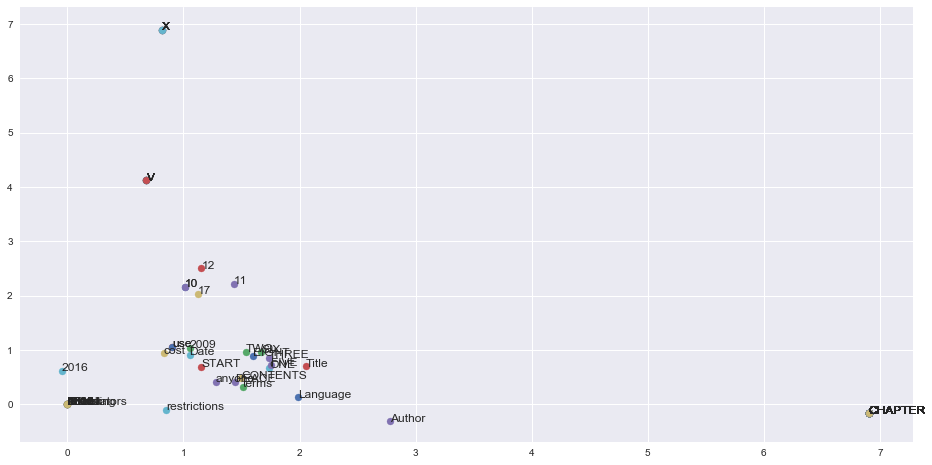

In [157]:
xs, ys = lsaOut[:,0], lsaOut[:,1]
for i in range(len(xs)): 
    plt.scatter(xs[i], ys[i])
    plt.annotate(warNounLabels[i], (xs[i], ys[i]))

# Document Vectorization

This uses a non-semantic technique for vectorizing documents, just using bag-of-words. We won't need any of the fancy features of SpaCy for this, just scikit-learn. We'll use a subset of the Inaugural Address Corpus that contains 20th and 21st century inaugural addresses. 

First, we'll vectorize the corpus using scikit-learn's `TfidfVectorizer` class. This creates a matrix of word frequencies. (It doesn't actually use TF-IDF, since we're turning that off in the options below.)

In [123]:
tfidf = TfidfVectorizer(input='filename', decode_error='ignore', use_idf=False)

In [130]:
inauguralFilenames = sorted(glob('input/inaugural/*'))

# Make labels by removing the directory name and .txt extension: 
labels = [filename.split('/')[1] for filename in inauguralFilenames]
labels = [filename.split('.')[0] for filename in labels]

# While we're at it, let's make a list of the lengths, so we can use them to plot dot sizes. 
lengths = [len(open(filename, errors='ignore').read())/100 for filename in inauguralFilenames]

# Add a manually compiled list of presidential party affiliations, 
# So that we can use this to color our dots. 
parties = 'rrrbbrrrbbbbbrrbbrrbrrrbbrrbr'

In [131]:
tfidfOut = tfidf.fit_transform(inauguralFilenames)

In [132]:
tfidfOut.shape

(29, 6177)

In [133]:
lsaOut = lsa.fit_transform(tfidfOut.todense())

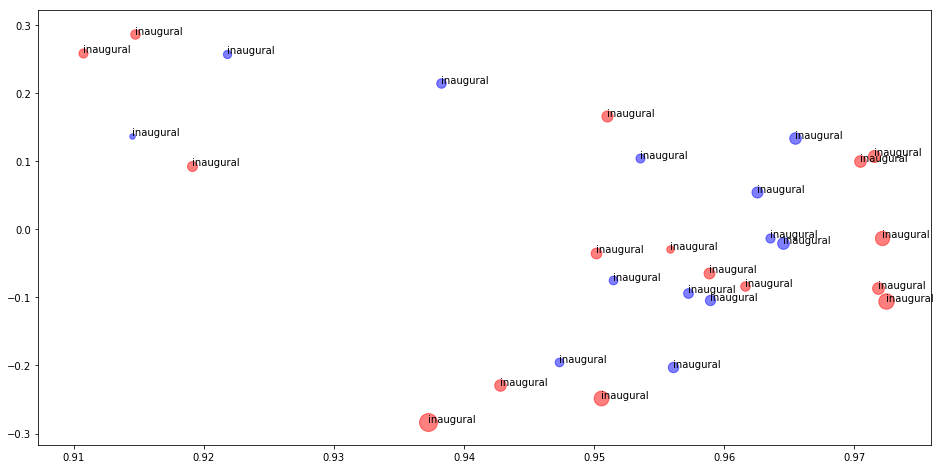

In [134]:
xs, ys = lsaOut[:,0], lsaOut[:,1]
for i in range(len(xs)): 
    plt.scatter(xs[i], ys[i], c=parties[i], s=lengths[i], alpha=0.5)
    plt.annotate(labels[i], (xs[i], ys[i]))

# Average Sentence Lengths

Let's load the Inaugural Address documents into SpaCy to analyze things like average sentence length. SpaCy makes this really easy. 

In [144]:
inaugural = [nlp(open(doc, errors='ignore').read()) for doc in inauguralFilenames]

In [145]:
sentLengths = [ np.mean([len(sent) for sent in doc.sents]) for doc in inaugural ]

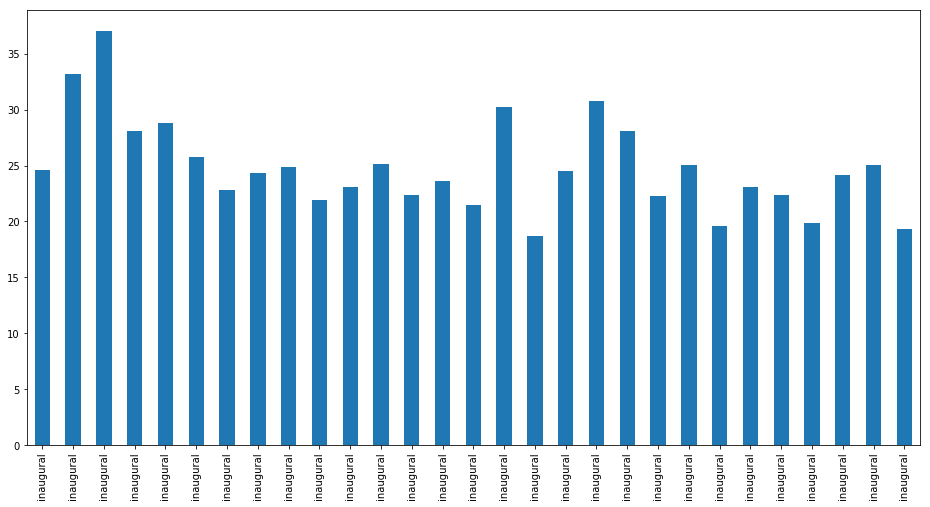

In [146]:
pd.Series(sentLengths, index=labels).plot(kind='bar')

# Term Frequency Distributions

This sort of thing you've probably already seen in the NLTK book, but it's made even easier in SpaCy. We're simply going to count the occurrences of words and divide by the total number of words in the document. 

In [147]:
# Create a Pandas Data Frame with each word counted in each document, 
# divided by the length of the document. 
inauguralSeries = [pd.Series(Counter(   
                    [word.string.strip().lower() 
                     for word in doc]))/len(doc) 
                     for doc in inaugural]
seriesDict = {label: series for label, series in zip(labels, inauguralSeries)}
inauguralDf = pd.DataFrame(seriesDict).T.fillna(0)

In [148]:
inauguralDf.head()

,,"""",'s,'ve,",",-,--,.,2017,20th,...,wonderful,words,work,workers,world,years,yes,you,young,your
inaugural,0.034863,0.001162,0.004067,0.001743,0.052295,0.000581,0.006392,0.051714,0.000581,0.000581,...,0.000581,0.001162,0.000581,0.001162,0.003486,0.001162,0.000581,0.006973,0.000581,0.006392


<h3>We can easily slice this data frame with words we're interested in, and plot those words across the corpus. For example, let's look at the proportions of the words "America" and "world":</h3>

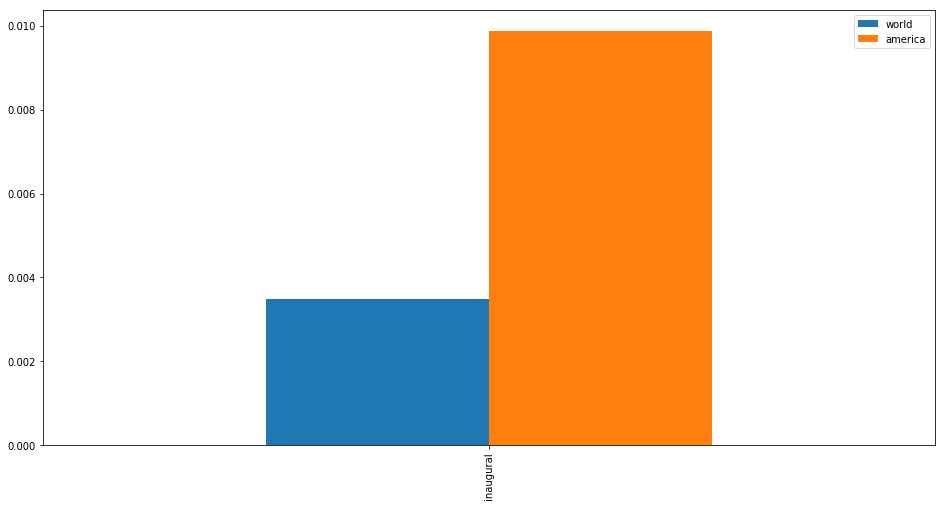

In [149]:
inauguralDf[['world', 'america']].plot(kind='bar')

<h3>We can even compute, the ratio of uses of the word "America" to uses of the word "world."</h3>

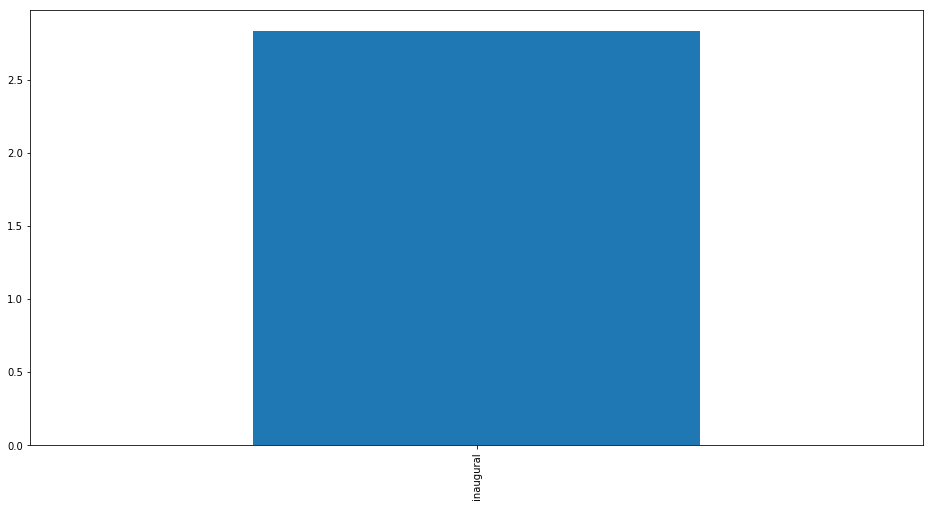

In [150]:
americaWorldRatio = inauguralDf['america']/inauguralDf['world']
americaWorldRatio.plot(kind='bar')

# Document Similarity Matrix

Using the `.similarity()` method from earlier that uses word vectors, we can very easily compute the document similarity between all the documents in our corpus. 

In [151]:
similarities = [ [doc.similarity(other) for other in inaugural] for doc in inaugural ]
similaritiesDf = pd.DataFrame(similarities, columns=labels, index=labels)

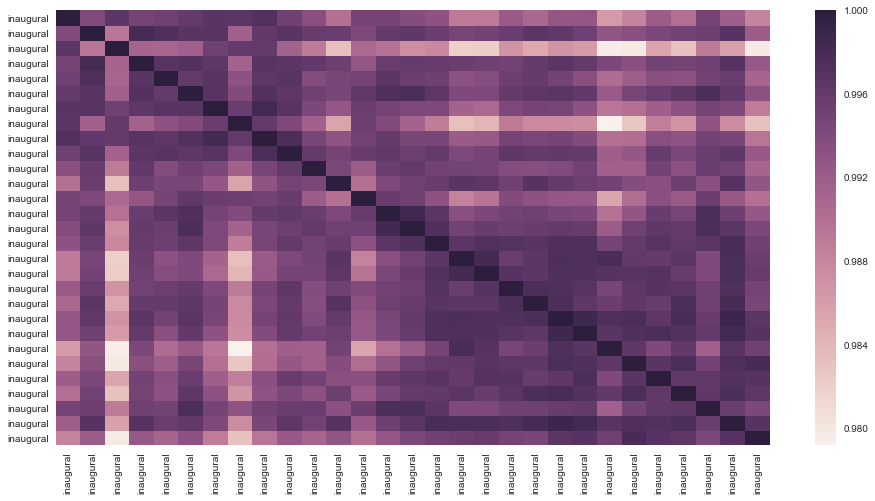

In [156]:
# Requires the Seaborn library. 
rcParams['figure.figsize'] = 16, 8
seaborn.heatmap(similaritiesDf)